### Board Visualization

In [1]:
import re
from PIL import Image, ImageDraw

class BadChessboard(ValueError):
    pass

def expand_blanks(fen):
    '''Expand the digits in an FEN string into spaces

    >>> expand_blanks("rk4q3")
    'rk    q   '
    '''
    def expand(match):
        return ' ' * int(match.group(0))
    return re.compile(r'\d').sub(expand, fen)

def check_valid(expanded_fen, n):
    '''Asserts an expanded FEN string is valid'''
    print(expanded_fen)
    match = re.compile(r'([KQBNRPkqbnrp ]{{{n}}}/){{{n}}}$'.format(n=n)).match
    if not match(expanded_fen + '/'):
        raise BadChessboard()

def expand_fen(fen, n):
    '''Preprocesses a fen string into an internal format.

    Each square on the chessboard is represented by a single 
    character in the output string. The rank separator characters
    are removed. Invalid inputs raise a BadChessboard error.
    '''
    expanded = expand_blanks(fen)
    check_valid(expanded, n)
    return expanded.replace('/', '')

def draw_board(n=8, sq_size=(20, 20)):
    '''Return an image of a chessboard.

    The board has n x n squares each of the supplied size.'''
    from itertools import cycle
    def square(i, j):
        return i * sq_size[0], j * sq_size[1]
    opaque_grey_background = 192, 255
    board = Image.new('LA', square(n, n), opaque_grey_background) 
    draw_square = ImageDraw.Draw(board).rectangle
    whites = ((square(i, j), square(i + 1, j + 1))
              for i_start, j in zip(cycle((0, 1)), range(n))
              for i in range(i_start, n, 2))
    for white_square in whites:
        draw_square(white_square, fill='white')#'white')
    return board

class DrawChessPosition(object):
    '''Chess position renderer.

    Create an instance of this class, then call 
    '''
    def __init__(self, n):
        '''Initialise, preloading pieces and creating a blank board.''' 
        self.n = n
        self.create_pieces()
        self.create_blank_board()

    def create_pieces(self):
        '''Load the chess pieces from disk.

        Also extracts and caches the alpha masks for these pieces. 
        '''
        whites = 'KQBNRP'
        piece_images = dict(
            zip(whites, (Image.open('pieces/%s.png' % p) for p in whites)))
        blacks = 'kqbnrp'
        piece_images.update(dict(
            zip(blacks, (Image.open('pieces/%s.png' % p) for p in blacks))))
        piece_sizes = set(piece.size for piece in piece_images.values())
        # Sanity check: the pieces should all be the same size
        assert len(piece_sizes) == 1
        self.piece_w, self.piece_h = piece_sizes.pop()
        self.piece_images = piece_images
        self.piece_masks = dict((pc, img.split()[3]) for pc, img in
                                 self.piece_images.items())

    def create_blank_board(self):
        '''Pre-render a blank board.'''
        self.board = draw_board(self.n, sq_size=(self.piece_w, self.piece_h))

    def point(self, i, j):
        '''Return the top left of the square at (i, j).'''
        w, h = self.piece_w, self.piece_h
        return i * h, j * w

    def square(self, i, j):
        '''Return the square at (i, j).'''
        t, l = self.point(i, j)
        b, r = self.point(i + 1, j + 1)
        return t, l, b, r

    def draw(self, fen):
        '''Return an image depicting the input position.

        fen - the first record of a FEN chess position.
        Clients are responsible for resizing this image and saving it,
        if required.
        '''
        board = self.board.copy()
        pieces = expand_fen(fen, self.n)
        images, masks, n = self.piece_images, self.piece_masks, self.n
        pts = (self.point(i, j) for j in range(n) for i in range(n))
        def not_blank(pt_pc):
            return pt_pc[1] != ' '
        for pt, piece in filter(not_blank, zip(pts, pieces)):
            board.paste(images[piece], pt, masks[piece])
        return board

In [2]:
renderer = DrawChessPosition(n=10)
fen = "r2q1rk1nb/B2Q1RK1NB/PP2PPBPNR/1np2np1NP/2Q3B1PR/3PP1b1KN/2N2N2PN/PP3PPPKN/3RKB1Rrn/3RKB1Rrn"
board = renderer.draw(fen)
#board.show()

r  q rk nb/B  Q RK NB/PP  PPBPNR/ np  np NP/  Q   B PR/   PP b KN/  N  N  PN/PP   PPPKN/   RKB Rrn/   RKB Rrn


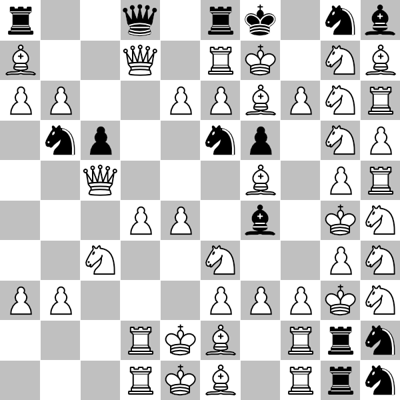

In [3]:
board.resize((400, 400))

### Figures

In [4]:
from itertools import product
from scipy.spatial import distance
import numpy as np
from math import hypot
from math import sqrt

MAX_DESK_SIZE = 100


class Figure:
    def __init__(self, name, coordinates):
        self._name = name
        self._coordinates = coordinates

    def get_step_coordinates(self, board_size):
        pass

    def attack(self, target_coordinates, board_size):
        list_possible_coordinates = self.get_step_coordinates(board_size)
        return target_coordinates in list_possible_coordinates

    def is_possible_attack(self, desk, desk_size):
        list_possible_coordinates = self.get_step_coordinates(desk_size)
        return any((desk[el[0], el[1]] for el in list_possible_coordinates
                    if (0 <= el[0] < desk_size) and (0 <= el[1] < desk_size))
                   )


class Pawn(Figure):
    def __init__(self, name, coordinates):
        super().__init__(name, coordinates)

    def get_step_coordinates(self, board_size):
        x, y = self._coordinates
        
        all_coordinates = list(product(range(board_size), range(board_size)))
        possible_coordinates = (coord for coord in all_coordinates 
                                if (abs(x - coord[0]) == 1 and y - coord[1] == 1)
                               )
        
        possible_coordinates = list(set(possible_coordinates))

        return possible_coordinates


class Knight(Figure):
    def __init__(self, name, coordinates):
        super().__init__(name, coordinates)

    def get_step_coordinates(self, board_size):
        x, y = self._coordinates
        all_coordinates = list(product(range(board_size), range(board_size)))
        
        possible_coordinates = (coord for coord in all_coordinates 
                                if ((abs(coord[0] - x) == 2 and abs(coord[1] - y) == 1) 
                                or (abs(coord[0] - x) == 1 and abs(coord[1] - y) == 2))
                                and coord != (x, y)
                               )
        possible_coordinates = list(set(possible_coordinates))

        return possible_coordinates


class Rook(Figure):
    def __init__(self, name, coordinates):
        super().__init__(name, coordinates)

    def get_step_coordinates(self, board_size):
        x, y = self._coordinates
        
        all_coordinates = list(product(range(board_size), range(board_size)))

        possible_coordinates = (coord for coord in all_coordinates 
                                if (coord[0] == x or coord[1] == y) and coord != (x, y)
                               )
        
        possible_coordinates = list(set(possible_coordinates))
            
        return possible_coordinates


class Bishop(Figure):
    def __init__(self, name, coordinates):
        super().__init__(name, coordinates)

    def get_step_coordinates(self, board_size):
        x, y = self._coordinates
          
        all_coordinates = list(product(range(board_size), range(board_size)))
        
        possible_coordinates = (coord for coord in all_coordinates 
                                if abs(coord[0] - x) == abs(coord[1] - y) and coord != (x, y)
                               )
        
        possible_coordinates = list(set(possible_coordinates))
            
        return possible_coordinates


class Queen(Figure):
    def __init__(self, name, coordinates):
        super().__init__(name, coordinates)

    def get_step_coordinates(self, board_size):
        x, y = self._coordinates
        
        bishop = Bishop(self._name, self._coordinates)
        rook = Rook(self._name, self._coordinates)

        rook_possible_coords = rook.get_step_coordinates(board_size)
        bishop_possible_coords = bishop.get_step_coordinates(board_size)
        
        list_possible_coordinates = rook_possible_coords + bishop_possible_coords
        list_possible_coordinates = list(set(list_possible_coordinates))
        list_possible_coordinates = [coord for coord in list_possible_coordinates if coord != (x, y)]
        
        return list_possible_coordinates


class King(Figure):
    def __init__(self, name, coordinates):
        super().__init__(name, coordinates)

    def get_step_coordinates(self, board_size):
        x, y = self._coordinates
                
        all_coordinates = list(product(range(board_size), range(board_size)))
        
        possible_coordinates = (coord for coord in all_coordinates 
                                if hypot(x - coord[0], y - coord[1]) <= sqrt(2) and coord != (x, y)
                               )
        
        possible_coordinates = list(set(possible_coordinates))
        
        return possible_coordinates

### Board Logic

In [5]:
import rstr
from collections import Counter
import numpy as np

# from visualize import DrawChessPosition
# from figures import King, Queen, Pawn, Rook, Knight, Bishop

REGXC = r'([{figures} ]{{{n}}}/){{{n}}}$'
CLASSES_MAPPING = {'B': Bishop, 'N': Knight, 'P': Pawn, 'R': Rook, 'K': King, 'Q': Queen}


class ChessBoard:

    def __init__(
            self,
            size,
            config,
            regex=REGXC
    ):
        self.size = size
        self.config = config
        self.regex = regex

    def generate_board(self):
        regex_tmp = self.regex.format(figures=('').join(self.config.keys()), n=self.size)
        gen = rstr.xeger(regex_tmp)
        gen = ('/').join(gen.split('/')[:-1])

        counter = Counter(gen)
        for piece, qty in self.config.items():
            real_qty = counter.get(piece)
            while real_qty > qty:
                for i, el in enumerate(gen):
                    if el == piece and np.random.uniform(0, 1) > 0.5 and real_qty > qty:
                        gen = gen[:i] + ' ' + gen[i + 1:]
                        real_qty -= 1

        renderer = DrawChessPosition(n=self.size)
        board = renderer.draw(gen)
        return board, gen

    def get_coordinates_map(self, board, gen):
        coords = np.zeros((self.size, self.size))
        coords_words = np.zeros((self.size, self.size)).astype(str)
        coords_dict = {}

        for col in self.config.keys():
            coords_dict[col] = []

        for i, row in enumerate(gen.split('/')):
            for j, col in enumerate(row):
                number = self.config.get(col)
                if number:
                    coords[i][j] = number
                    coords_words[i][j] = col
                    coords_dict[col].append((i, j))

        coords_words = [[' ' if el1 == '0.0' else el1 for el1 in el] for el in coords_words]

        figures_mapping = {}

        for key, coords_figure in coords_dict.items():
            for coord in coords_figure:
                figures_mapping[coord] = CLASSES_MAPPING.get(key)(key, coord)

        return coords, coords_words, coords_dict, figures_mapping

    def show_field(self):
        board, gen = self.generate_board()
        board.show()


In [6]:
CONFIG = {'B': 3, 'N': 2, 'P': 4, 'R': 1}
SIZE = 10

In [7]:
chess_board = ChessBoard(SIZE, CONFIG)

In [8]:
board, gen = chess_board.generate_board()

B    P    /N         /      PP  /          /  N       /    B     /        P /          /    B     /      R   


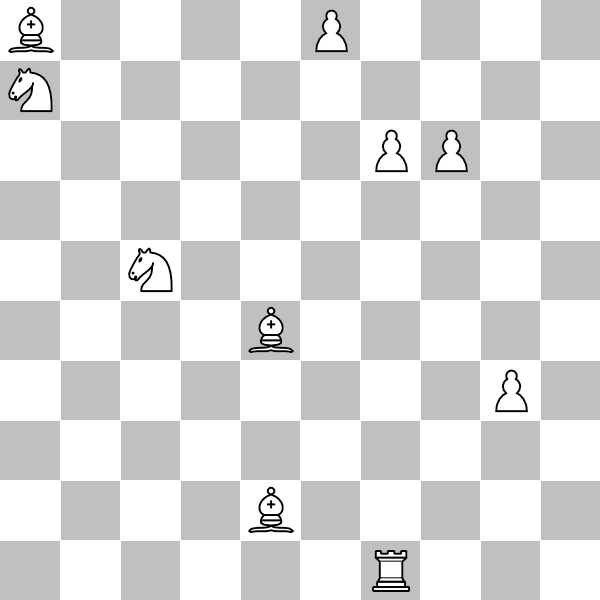

In [9]:
board

In [10]:
coords, coords_words, coords_dict, figures_mapping = chess_board.get_coordinates_map(board, gen)

In [11]:
coords

array([[3., 0., 0., 0., 0., 4., 0., 0., 0., 0.],
       [2., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 4., 4., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 2., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 3., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 4., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 3., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

In [12]:
coords_words

[['B', ' ', ' ', ' ', ' ', 'P', ' ', ' ', ' ', ' '],
 ['N', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', 'P', 'P', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', 'N', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', 'B', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'P', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', 'B', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', 'R', ' ', ' ', ' ']]

In [13]:
coords_dict

{'B': [(0, 0), (5, 4), (8, 4)],
 'N': [(1, 0), (4, 2)],
 'P': [(0, 5), (2, 6), (2, 7), (6, 8)],
 'R': [(9, 6)]}

## DFS Algorithm

In [14]:
from copy import deepcopy

In [15]:
coords_empty = np.zeros((SIZE, SIZE)).astype(str)

In [16]:
def check_constraints(figures_list, figure_idx, target_coordinates, board_size):
    
    for idx, figure in enumerate(figures_list):
#         if idx != figure_idx:
        if figure.attack(target_coordinates, board_size):
            return True
    return False

In [17]:
figures_list = list(figures_mapping.values())

In [18]:
def dfs(figure_idx, coords, figures_list):
#     print(np.array([el._coordinates for el in figures_list]), '\n')

    if figure_idx >= len(figures_list):
        return coords
    
    for i, j in product(range(coords.shape[0]), range(coords.shape[0])):
        raw_coords = tuple(zip(*np.where(coords == '0.0')))
        non_raw_coords = tuple(zip(*np.where(coords != '0.0')))
        
        tmp_fig = figures_list[figure_idx]
        tmp_fig._coordinates = (i, j)
        
        if ((i, j) in raw_coords and not len(set(non_raw_coords) &
                                             set(tmp_fig.get_step_coordinates(coords.shape[0]))
                                            )):
            is_possible_attack = check_constraints(figures_list, figure_idx, (i, j), coords.shape[0])

            if not is_possible_attack:
                coords[i, j] = figures_list[figure_idx]._name
                figures_list[figure_idx]._coordinates = (i, j)
                
                coords = dfs(figure_idx + 1, coords, figures_list)
                if coords is not None:
                    return coords
            
    return None

In [27]:
coords_cp = deepcopy(coords)
figures_mapping_cp = deepcopy(figures_mapping)
figures_list_cp = deepcopy(figures_list)
coords_words_cp = deepcopy(coords_words)

In [28]:
coords_words_cp = np.array(coords_words_cp)

In [29]:
empty_coords = np.zeros((SIZE, SIZE)).astype(str)

In [30]:
coords_res = dfs(0, empty_coords, figures_list_cp)

In [31]:
coords_res = [[' ' if el == '0.0' else el for el in el1] for el1 in coords_res]

In [32]:
new_gen = ('/').join([('').join([el if el != '0.0' else ' ' for el in row]) for row in coords_res])
new_gen

'BBNBNP PPP/          /      R   /          /          /          /          /          /          /          '

In [33]:
new_renderer = DrawChessPosition(n=10)
new_board = renderer.draw(new_gen)

BBNBNP PPP/          /      R   /          /          /          /          /          /          /          


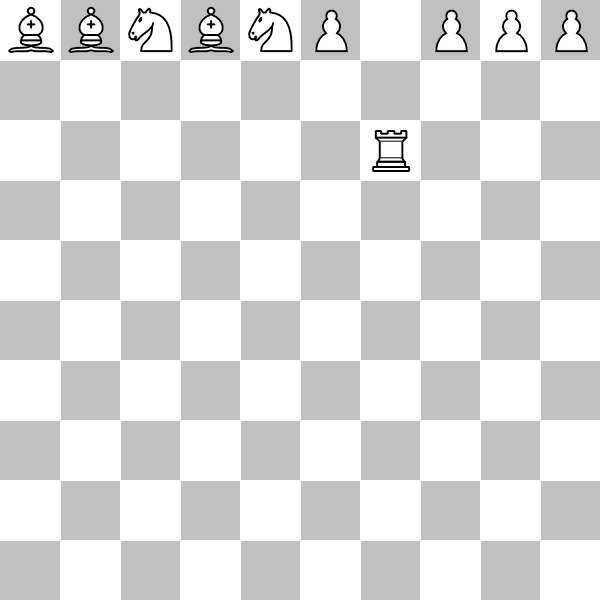

In [34]:
new_board

## 2

In [27]:
CONFIG1 = {'P': 15}
SIZE1 = 5

In [28]:
chess_board1 = ChessBoard(SIZE1, CONFIG1)

In [29]:
board1, gen1 = chess_board1.generate_board()

  PP /   PP/  P  /PP  P/P PPP


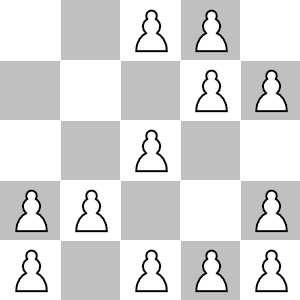

In [30]:
board1

In [31]:
coords4, coords_words4, coords_dict4, figures_mapping4 = chess_board1.get_coordinates_map(board1, gen1)

In [32]:
coords4

array([[ 0.,  0., 15., 15.,  0.],
       [ 0.,  0.,  0., 15., 15.],
       [ 0.,  0., 15.,  0.,  0.],
       [15., 15.,  0.,  0., 15.],
       [15.,  0., 15., 15., 15.]])

In [33]:
coords_empty1 = np.zeros((SIZE1, SIZE1)).astype(str)
figures_list4 = list(figures_mapping4.values())

In [34]:
coords4_cp = deepcopy(coords4)
figures_mapping4_cp = deepcopy(figures_mapping4)
figures_list4_cp = deepcopy(figures_list4)
coords_words4_cp = deepcopy(coords_words4)

In [35]:
coords_words4_cp = np.array(coords_words4_cp)

In [36]:
empty_coords4 = np.zeros((SIZE1, SIZE1)).astype(str)

In [37]:
coords_res4 = dfs(0, empty_coords4, figures_list4_cp)

In [38]:
coords_res4

array([['P', 'P', 'P', 'P', 'P'],
       ['0.0', '0.0', '0.0', '0.0', '0.0'],
       ['P', 'P', 'P', 'P', 'P'],
       ['0.0', '0.0', '0.0', '0.0', '0.0'],
       ['P', 'P', '0.0', '0.0', '0.0']], dtype='<U32')

In [39]:
coords_res4 = [[' ' if el == '0.0' else el for el in el1] for el1 in coords_res4]

In [40]:
new_gen4 = ('/').join([('').join([el if el != '0.0' else ' ' for el in row]) for row in coords_res4])
new_gen4

'PPPPP/     /PPPPP/     /PP   '

In [41]:
new_renderer4 = DrawChessPosition(n=SIZE1)
new_board4 = new_renderer4.draw(new_gen4)

PPPPP/     /PPPPP/     /PP   


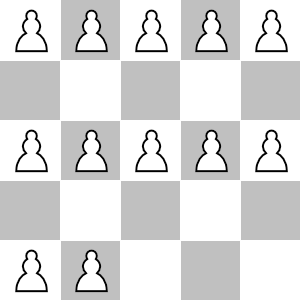

In [42]:
new_board4

## 3

In [43]:
CONFIG1 = {'P': 3, 'K': 1, 'Q': 2, 'R': 2, 'B': 1, 'N': 2}
SIZE1 = 8

In [44]:
chess_board1 = ChessBoard(SIZE1, CONFIG1)

In [45]:
board1, gen1 = chess_board1.generate_board()

      P /        / N  P   /  B     /P  Q  R /   Q  R / K      /    N   


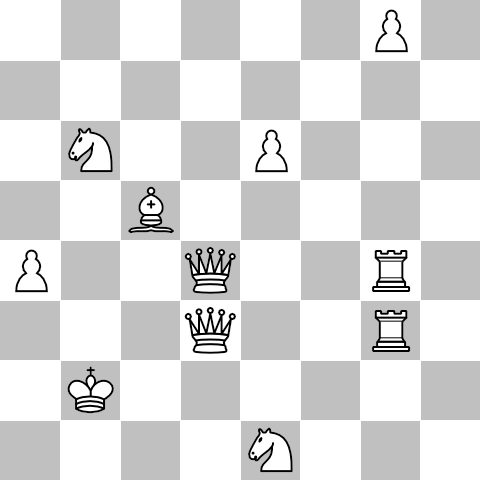

In [46]:
board1

In [47]:
coords4, coords_words4, coords_dict4, figures_mapping4 = chess_board1.get_coordinates_map(board1, gen1)

In [48]:
coords4

array([[0., 0., 0., 0., 0., 0., 3., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 2., 0., 0., 3., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [3., 0., 0., 2., 0., 0., 2., 0.],
       [0., 0., 0., 2., 0., 0., 2., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 2., 0., 0., 0.]])

In [49]:
coords_empty1 = np.zeros((SIZE1, SIZE1)).astype(str)
figures_list4 = list(figures_mapping4.values())

In [50]:
coords4_cp = deepcopy(coords4)
figures_mapping4_cp = deepcopy(figures_mapping4)
figures_list4_cp = deepcopy(figures_list4)
coords_words4_cp = deepcopy(coords_words4)

In [51]:
coords_words4_cp = np.array(coords_words4_cp)

In [52]:
empty_coords4 = np.zeros((SIZE1, SIZE1)).astype(str)

In [53]:
coords_res4 = dfs(0, empty_coords4, figures_list4_cp)

In [54]:
coords_res4

In [55]:
coords_res4 = [[' ' if el == '0.0' else el for el in el1] for el1 in coords_res4]

TypeError: 'NoneType' object is not iterable

In [56]:
new_gen4 = ('/').join([('').join([el if el != '0.0' else ' ' for el in row]) for row in coords_res4])
new_gen4

TypeError: 'NoneType' object is not iterable

In [57]:
new_renderer4 = DrawChessPosition(n=SIZE1)
new_board4 = new_renderer4.draw(new_gen4)

PPPPP/     /PPPPP/     /PP   


BadChessboard: 

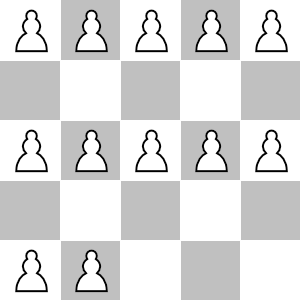

In [58]:
new_board4

## Filtering

In [59]:
CONFIG_LAST = {'P': 3, 'K': 1, 'R': 2, 'B': 1, 'N': 2}
SIZE_LAST = 10

In [60]:
chess_board_last = ChessBoard(SIZE_LAST, CONFIG_LAST)

In [61]:
board_last, gen_last = chess_board_last.generate_board()

 P        /          /          /  P       / N        /        R /         B/ P    K   /          / NR       


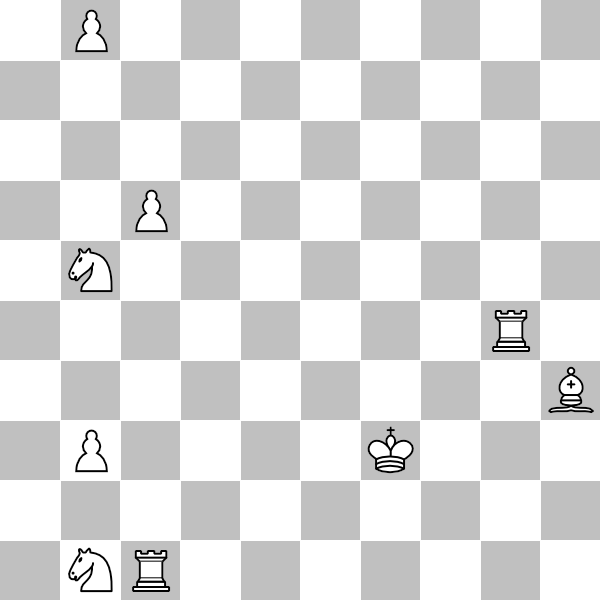

In [62]:
board_last

In [63]:
coords_last, coords_words_last, coords_dict_last, figures_mapping_last = chess_board_last.get_coordinates_map(
    board_last, gen_last)

In [64]:
def create_constraints(board, use_all_domains):
    n_figures = board[board != 0].shape[0]
    universal_domain = [(x, y) for x in range(board.shape[0]) for y in range(board.shape[1])]
    domains = [deepcopy(universal_domain) for i in range(n_figures)]
    
    if not use_all_domains:
        for i in range(len(domains) - 1):
            n_to_drop = np.random.randint(0, len(universal_domain) - 2)
            for j in range(n_to_drop):
                domain_to_drop = np.random.randint(0, len(domains[i]))
                domains[i].pop(domain_to_drop)
                
        last_domain_preserve = np.random.randint(0, len(universal_domain))
        domains = [domains[-1][last_domain_preserve]]
    
    return domains

In [65]:
coords_words_last

[[' ', 'P', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', 'P', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', 'N', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'R', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'B'],
 [' ', 'P', ' ', ' ', ' ', ' ', 'K', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', 'N', 'R', ' ', ' ', ' ', ' ', ' ', ' ', ' ']]

In [66]:
domains = create_constraints(coords_last, True)

In [67]:
figures_list_last = list(figures_mapping_last.values())

In [68]:
def is_one_possible_attack(board, figures_list, figure_idx, figure_jdx, coords_i, coords_j):
    figure_i = figures_list[figure_idx]
    figure_j = figures_list[figure_jdx]
    
    figure_i_tmp = deepcopy(figure_i)
    figure_j_tmp = deepcopy(figure_j)

    figure_i_tmp._coordinates = coords_i
    figure_j_tmp._coordinates = coords_j
    
    return not any((figure_i_tmp.attack(coords_j, board.shape[0]), figure_j_tmp.attack(coords_i, board.shape[0])))

In [69]:
def is_any_possible_attack(board, figures_list, figure_idx, figure_jdx, current_domain, domains):
    return not any(is_one_possible_attack(board, figures_list, figure_idx, figure_jdx, current_domain, coords_j)
              for coords_j in domains
              )

In [70]:
def make_revision(board, figures_list, domains, idx, jdx):
    old_domain = deepcopy(domains[idx])
    current_domain = deepcopy(domains[idx])
    
    for cur_domain in current_domain:
        if is_any_possible_attack(board, figures_list, idx, jdx, cur_domain, domains[jdx]):
            current_domain.remove(cur_domain)
    
    if set(old_domain) != set(current_domain):
        domains[idx] = current_domain
        
        for k in range(len(figures_list)):
            if k not in (idx, jdx):
                make_revision(board, figures_list, domains, idx, k)

def filtering_process(board, figures_list, domains, idx):
    for j in range(len(figures_list)):
        if j != idx:
            make_revision(board, figures_list, domains, idx, j)

In [71]:
def find_solution(board, figures_list, domains):
    
    for i in range(len(figures_list)):
        filtering_process(board, figures_list, domains, i)
        if len(domains[i]) == 0:
            print('No solution...')
            return None
        else:
            idx_to_choose = np.random.choice(range(len(domains[i])))
            domains[i] = [domains[i][idx_to_choose]] #[domains[i][0]]
    
    for i in range(len(domains)):
        figures_list[i]._coordinates = np.array(domains[i][0])
        
    return figures_list

In [72]:
figures_sol = find_solution(coords_last, figures_list_last, domains)

In [73]:
coords_sol = np.zeros((SIZE_LAST, SIZE_LAST)).astype(str)

for figure in figures_sol:
    coords_sol[figure._coordinates[0], figure._coordinates[1]] = figure._name

coords_sol = [[' ' if el1 == '0.0' else el1 for el1 in el] for el in coords_sol]

In [74]:
coords_sol

[[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', 'K', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', 'R', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', 'P', ' ', ' ', ' ', ' ', 'N', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', 'P', ' ', ' ', ' ', ' ', ' '],
 ['N', 'B', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']]

In [75]:
coords_words_last

[[' ', 'P', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', 'P', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', 'N', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'R', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'B'],
 [' ', 'P', ' ', ' ', ' ', ' ', 'K', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', 'N', 'R', ' ', ' ', ' ', ' ', ' ', ' ', ' ']]

In [76]:
sol_gen = ('/').join([('').join([el if el != '0.0' else ' ' for el in row]) for row in coords_sol])
sol_gen

'          /          /          /    K     /  R       /          / P    N   /          /    P     /NB        '

In [77]:
sol_renderer = DrawChessPosition(n=SIZE_LAST)
sol_board = sol_renderer.draw(sol_gen)

          /          /          /    K     /  R       /          / P    N   /          /    P     /NB        


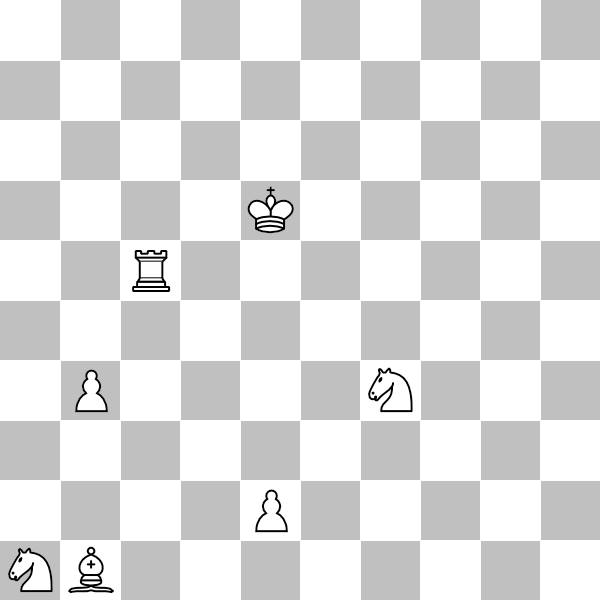

In [78]:
sol_board

## ABT

In [825]:
CONFIG_LAST = {'P': 8, 'N': 2, 'Q': 1}
SIZE_LAST = 8

In [826]:
chess_board_last = ChessBoard(SIZE_LAST, CONFIG_LAST)

In [827]:
board_last, gen_last = chess_board_last.generate_board()

        /       P/   N    /    P  P/P       /  Q P P /P       /     NP 


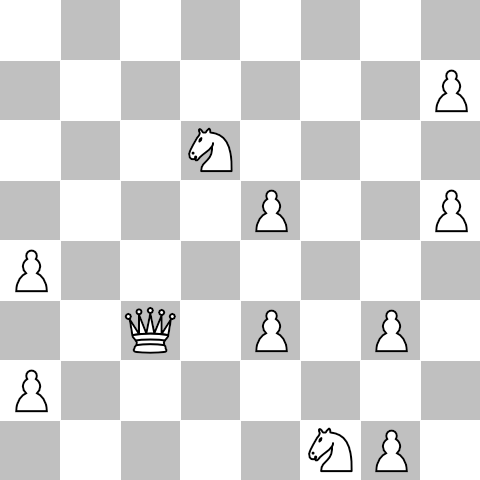

In [828]:
board_last

In [829]:
coords_last, coords_words_last, coords_dict_last, figures_mapping_last = chess_board_last.get_coordinates_map(
    board_last, gen_last)

In [830]:
coords_words_last

[[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', 'P'],
 [' ', ' ', ' ', 'N', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', 'P', ' ', ' ', 'P'],
 ['P', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', 'Q', ' ', 'P', ' ', 'P', ' '],
 ['P', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', 'N', 'P', ' ']]

In [831]:
coords_last

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 8.],
       [0., 0., 0., 2., 0., 0., 0., 0.],
       [0., 0., 0., 0., 8., 0., 0., 8.],
       [8., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 8., 0., 8., 0.],
       [8., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 2., 8., 0.]])

In [832]:
all_domain = list(product(range(SIZE_LAST), range(SIZE_LAST)))

In [35]:
all_domain = list(product(range(SIZE), range(SIZE)))

In [36]:
import random
import copy


class Agent:
    def __init__(self, figure, priority, neighbor_list, domain, board):
        self.figure = figure
        self.priority = priority
        self.neighbors_list = copy.deepcopy(neighbor_list)
        self.agent_domain = domain
        self.consistent = True
        self.constraints = []
        self.board = board

    def check_consistency(self):
        self.consistent = True
        for neighbor in self.neighbors_list:
            if (neighbor.figure.attack(self.figure._coordinates, self.board.shape[0])
                or self.figure._coordinates == neighbor.figure._coordinates):
                self.consistent = False

    def change_value(self):
        self.figure._coordinates = random.choice(self.agent_domain)

    def check_local_view(self):
        #print("check_local_view for {0}".format(self.figure._name))
        self.check_consistency()
        if not self.consistent:
            #print("agent {0} value is not consistent with neighbor(s)".format(self.figure._name))
            old_value = self.figure._coordinates
            for domain in self.agent_domain:
                self.figure._coordinates = domain
                self.check_consistency()
                if self.consistent:
                    break
            if not self.consistent:
                for agents in self.neighbors_list:
                    if agents.priority == self.priority - 1:
                        master_agent = agents
                #print("backtracking for agent {0}".format(self.figure._name))
                backtrack(master_agent)
            else:
                for agents in self.neighbors_list:
                    send_handle_ok(self)

    def handle_ok(self, agent):
        for neighbor in self.neighbors_list:
            #print("handle_ok? for agent {0}".format(agent.figure._name))
            if neighbor.figure._name == agent.figure._name:
                neighbor.figure._coordinates = agent.figure._coordinates
                neighbor.priority = agent.priority
                self.check_local_view()

    def handle_nogood(self, agent, nogood_list):
        self.constraints.append(nogood_list)
        for agent_in_nogood in nogood_list:
            if any(neighbor_agent['name'] == agent_in_nogood[0] for neighbor_agent in self.neighbors_list):
                pass
            else:
                self.neighbors_list.append(
                    {'name': agent_in_nogood[0], 'value': agent_in_nogood[1], 'priority': agent_in_nogood[2]})
        old_value = self.figure._coordinates
        self.check_local_view()
        if old_value != self.figure._coordinates:
            for agents in self.neighbors_list:
                send_handle_ok(self)


def backtrack(master_agent):
    higher_priority_agents = []
    higher_domains = []
    for neighbor in master_agent.neighbors_list:
        if neighbor.priority < master_agent.priority:
            higher_priority_agents.append(neighbor)
    for agent in higher_priority_agents:
        higher_domains.append(agent.figure._coordinates)
    if master_agent.agent_domain == higher_domains:
        print("no_solution")
    else:
        if not (master_agent.figure._coordinates in higher_domains):
            print("no_solution")
            return 0
        while master_agent.figure._coordinates in higher_domains:
            master_agent.figure._coordinates = random.choice(master_agent.agent_domain)
        for agents in master_agent.neighbors_list:
            if agents.priority > master_agent.priority:
                send_handle_ok(master_agent)


def send_handle_ok(agent):
    for agents in agent.neighbors_list:
        if agents:
            if agents.priority > agent.priority:
                agents.handle_ok(agent)


def abt(agent_list):
    processed_agents = []
    for i, agent in enumerate(agent_list):
        agent.check_consistency()
        send_handle_ok(agent)
        processed_agents.append(agent)
        
#         if i > 0:
        new_domain = list(set(all_domain) - set([ag.figure._coordinates for ag in processed_agents]))
        agent.agent_domain = new_domain

        new_neighbours = []
        for neighbour in agent.neighbors_list:
            neighbour.agent_domain = new_domain

            new_neighbours.append(neighbour)

        agent.neighbors_list = new_neighbours

In [834]:
coords_dict_last

{'P': [(1, 7), (3, 4), (3, 7), (4, 0), (5, 4), (5, 6), (6, 0), (7, 6)],
 'N': [(2, 3), (7, 5)],
 'Q': [(5, 2)]}

In [835]:
figures_mapping_last

{(1, 7): <__main__.Pawn at 0x7faaa1e12880>,
 (3, 4): <__main__.Pawn at 0x7faaa1e12ee0>,
 (3, 7): <__main__.Pawn at 0x7faaa1e12c40>,
 (4, 0): <__main__.Pawn at 0x7faaa1e12430>,
 (5, 4): <__main__.Pawn at 0x7faaa1e12970>,
 (5, 6): <__main__.Pawn at 0x7faaa1e12730>,
 (6, 0): <__main__.Pawn at 0x7faaa1e12580>,
 (7, 6): <__main__.Pawn at 0x7faaa1e126d0>,
 (2, 3): <__main__.Knight at 0x7faaa1e12280>,
 (7, 5): <__main__.Knight at 0x7faaa1e121f0>,
 (5, 2): <__main__.Queen at 0x7faaa1822220>}

In [37]:
figures_mapping_last_changed_names = deepcopy(figures_mapping)

for coords1, figure in figures_mapping_last_changed_names.items():
    new_fig = deepcopy(figure)
    new_fig._name = '{}_{}'.format(figure._name, coords1)
    figures_mapping_last_changed_names[coords1] = new_fig

In [38]:
agents = [Agent(figure, i + 1, [], all_domain, coords) 
          for i, figure in enumerate(figures_mapping_last_changed_names.values())]

In [39]:
for idx, agent in enumerate(agents):
    agent.neighbors_list.extend([ag for ag_idx, ag in enumerate(agents) if ag_idx != idx])

In [33]:
agents[0].figure

In [34]:
[el.figure for el in agents[0].neighbors_list]

In [40]:
abt(agents)

In [842]:
agents[0].figure._coordinates

(1, 7)

In [843]:
for agent in agents:
    print(agent.figure._name, agent.figure._coordinates)

P_(1, 7) (1, 7)
P_(3, 4) (0, 0)
P_(3, 7) (3, 7)
P_(4, 0) (4, 0)
P_(5, 4) (0, 1)
P_(5, 6) (0, 3)
P_(6, 0) (6, 0)
P_(7, 6) (7, 6)
N_(2, 3) (2, 3)
N_(7, 5) (7, 5)
Q_(5, 2) (5, 2)


In [41]:
coords_sol = np.zeros((SIZE, SIZE)).astype(str)
coords_sol = [[' ' if el1 == '0.0' else el1 for el1 in el] for el in coords_sol]

In [42]:
for agent in agents:
    coords_sol[agent.figure._coordinates[0]][agent.figure._coordinates[1]] = agent.figure._name.split('_')[0]

In [43]:
coords_sol

[['B', 'B', 'N', 'P', ' ', 'P', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', 'P', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', 'N', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'P', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', 'B', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', 'R', ' ', ' ', ' ']]

In [44]:
sol_gen = ('/').join([('').join([el if el != '0.0' else ' ' for el in row]) for row in coords_sol])
sol_gen

'BBNP P    /          /       P  /          /  N       /          /        P /          /    B     /      R   '

In [45]:
sol_renderer = DrawChessPosition(n=SIZE)
sol_board = sol_renderer.draw(sol_gen)

BBNP P    /          /       P  /          /  N       /          /        P /          /    B     /      R   


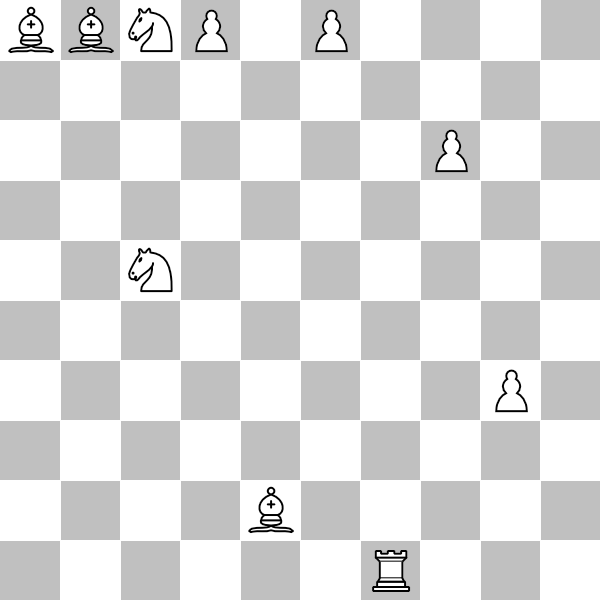

In [46]:
sol_board